In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1) 

/home/ikea/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarni

In [2]:
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools
from eden.util import random_bipartition_iter,selection_iterator
import random

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)


RFAM="RF01725"
#cutoff 162 (44.0)
#cutoff 1725 (38.0)
#cutoff rest (29)


def get_sequences_with_names(size=9999, rand=True):
    it = fasta_to_sequence("../toolsdata/%s.fa" % RFAM)
    it = list(it)
    if rand:
        #sequences , boring = random_bipartition_iter(it,.9,random_state=random.random())
        r=range(len(it))
        random.shuffle(r)
        return selection_iterator(it,r[:size])
    else:
        sequences = itertools.islice(it, size)
    return sequences


In [3]:
'''
SET UP THE SAMPLERS/// FITTING AND SAMPLING
'''

import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools

NJOBS=4
def fit_sample(sequences, random_state=random.random()):
    '''
    in: sequence list.. 
    [(NAME,SEQUENCE),()... ] 
    
    out: list of learned sequences
    LEARNED [ (NAME,SEQUENCE),()... ]
    '''
    
    # fit a sampler
    sequences = list(sequences)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1) # with .5 it also works for the fewer ones.. 
    sampler=rna.AbstractSampler(radius_list=[0], # war 0,1
                                thickness_list=[2], # war 2 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(sequences,grammar_n_jobs=NJOBS,grammar_batch_size=1)
        
    #logger.info('graph grammar stats:')
    dataset_size, interface_counts, core_counts, cip_counts = sampler.grammar().size()
    #logger.info('#instances:%d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (dataset_size, interface_counts, core_counts, cip_counts))
    
    sequences = [ b for a ,b in sequences  ]
    sequences = sampler.sample(sequences,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=NJOBS,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.4,
                            improving_linear_start=0.1,
                            max_size_diff=10,
                            accept_min_similarity=0.6,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=2,
                            monitor=False)
    
    result=[]
    for li in sequences:
        result+=li
        
    return [r[1] for r in result]    
    '''    
    r2=[]
    for r in result:
        r2.append(r[1])
    
    #print 'grgen result is rabun not was is documentedOo.',r2
    return r2
    '''


In [4]:
'''
evaluation for one data-point
'''
import numpy as np
def evaluate(repeats,size,fitsample):
    print 'eval:',
    means=[]
    stds=[]
    for i in range(repeats):
        sequences=get_sequences_with_names(size=size, rand=10)
        zz=fitsample(sequences)
        #print zz[:3]
        # z=[b for a ,b in zz]
        result=rna.infernal_checker(zz,cmfile='../toolsdata/%s.cm' % RFAM, cmsearchbinarypath='../toolsdata/cmsearch')
        
        a = np.array(result)
        means.append( np.mean(a, axis=0) )
        stds.append( np.std(a, axis=0) )
    
    means.sort()
    stds.sort()
    print (size,means,stds)
    return [means[repeats/2]*100,stds[repeats/2]*100]
    


In [56]:
'''
SETUP DRAWING OF RESULTS
'''
import numpy as np
import matplotlib.pyplot as plt
def make_two_bar_plot(labels=('G1', 'G2', 'G3', 'G4', 'G5'),means=[(20, 35),(20, 85)],stds=[(2, 3),(3, 3)]):
    N = len(labels)
    ind = np.arange(N) 
    width = 0.35
    plt.figure(figsize=(14, 5))
    
    
    fig, ax = plt.subplots()
    #ax.ylim(0.0,100)
    plt.ylim(0,100)
    rects1 = ax.bar(ind, means[0], width, yerr=stds[0], color='#69ACEA',edgecolor='None',ecolor='#444444')
    rects2 = ax.bar(ind + width, means[1], width, color='#8DDD82', yerr=stds[1], edgecolor='None',ecolor='#444444')
    plt.axhline(y=38, color='black',linewidth=3)
    # add some text for labels, title and axes ticks
    ax.set_ylabel('something ylabel')
    ax.set_title('title')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(labels)
    ax.legend((rects1[0], rects2[0]), ('advanced', 'regular'))
    plt.show()

    
def make_inbetween_plot(labels=('G1', 'G2', 'G3', 'G4', 'G5'),means=[(20, 35),(20, 85)],stds=[(2, 3),(3, 3)]):
    #N = len(labels)
    #ind = np.arange(N) 
    #width = 0.35
    plt.figure(figsize=(14, 5))
    fig, ax = plt.subplots()
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(14)
    
    #ax.ylim(0.0,100)
    plt.ylim(0,80)
    plt.xlim(0,410)
    plt.axhline(y=38, color='black',linewidth=3)
    ax.fill_between(labels,means[0],means[1],facecolor='#fcfc88')
    ax.errorbar(labels, means[0], yerr= stds[0], fmt='o')
    ax.errorbar(labels, means[1], yerr= stds[1], fmt='x')
    ax.plot(labels,means[0],label='new CIP',color='b')
    ax.plot(labels,means[1],label='default CIP',color='g')
    
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Infernal bit score\n(higher is better)',fontsize=16)
    ax.set_xlabel('number of training sequences',fontsize=18)
    ax.legend(loc='lower right')

    plt.show()
    

size = [10, 20, 50, 100, 200, 400]
means = [56.725, 61.39310344827585, 56.91238095238095, 52.69766355140186, 47.822811059907835, 48.00770975056689]
means2 = [11.473076923076924, 10.367272727272727, 14.535714285714288, 12.277238805970152, 13.774444444444445, 14.71313598519889]
stds = [13.075456463481306, 12.05292727456074, 12.772826030571943, 14.369074946790544, 15.520753474342225, 14.701883300962383]
stds2 = [15.433486320336051, 14.398291039456005, 16.261699399107673, 13.963606495020159, 14.96668739922383, 14.970472924155272]


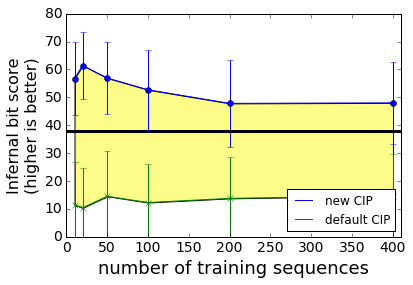

CPU times: user 140 ms, sys: 4 ms, total: 144 ms
Wall time: 139 ms


In [57]:
%%time

# values for the real run  
sizes=[10,20,50,100,200,400]
repeats=5

# values for a test-run
#sizes=[10,20]
#repeats=3


if False:
    means=[]
    stds=[]
    for size in sizes:
        m,s=evaluate(repeats,size,fit_sample)
        means.append(m)
        stds.append(s)
    means2=[]
    stds2=[]
    for size in sizes:
        m,s=evaluate(repeats,size,fit_sample_noabstr)
        means2.append(m)
        stds2.append(s)
else:
    size =  [10, 20, 50, 100, 200, 400]
    means = [56.725000000000001, 61.393103448275852, 56.91238095238095, 52.69766355140186, 47.822811059907835, 48.007709750566889]
    means2 = [11.473076923076924, 10.367272727272727, 14.535714285714288, 12.277238805970152, 13.774444444444445, 14.713135985198891]
    stds = [13.075456463481306, 12.052927274560741, 12.772826030571943, 14.369074946790544, 15.520753474342225, 14.701883300962383]
    stds2 = [15.433486320336051, 14.398291039456005, 16.261699399107673, 13.963606495020159, 14.966687399223829, 14.970472924155272] 
    
print 'size = %s' % str(sizes)
print 'means = %s' % str(means)
print 'means2 = %s' % str(means2)
print 'stds = %s' % str(stds)
print 'stds2 = %s' % str(stds2)

make_inbetween_plot(sizes,[means,means2],[stds,stds2])


---

In [7]:

def make_bar_plot(labels=('G1', 'G2', 'G3', 'G4', 'G5'),means=(20, 35, 30, 35, 27),stds=(2, 3, 4, 1, 2)):
    N = len(labels)
    ind = np.arange(N) 
    width = .5 #0.35
    plt.figure(figsize=(14, 5))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(18)
        
    p1 = plt.bar(ind, means, width, color='#69ACEA', yerr=stds,edgecolor='None',ecolor='#444444')
    #p2 = plt.bar(ind, means, width, color='#8DDD82', yerr=stds,edgecolor='None',ecolor='#444444')
    
    plt.axhline(y=38, color='black',linewidth=3)
    plt.ylabel("log odds score",fontsize=20)
    plt.xlabel("number of graphs",fontsize=20)
    #plt.xlabel("number of graphs",fontsize=20)
    plt.title('Scores by training size',fontsize=20)
    plt.xticks(ind + width/2, labels )
    plt.yticks(np.arange(0, 100, 10))
    plt.show()

size: [10, 20]
means: [61.46, 62.02894736842106]
stds: [14.641120175724259, 12.33487141134333]


/home/ikea/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


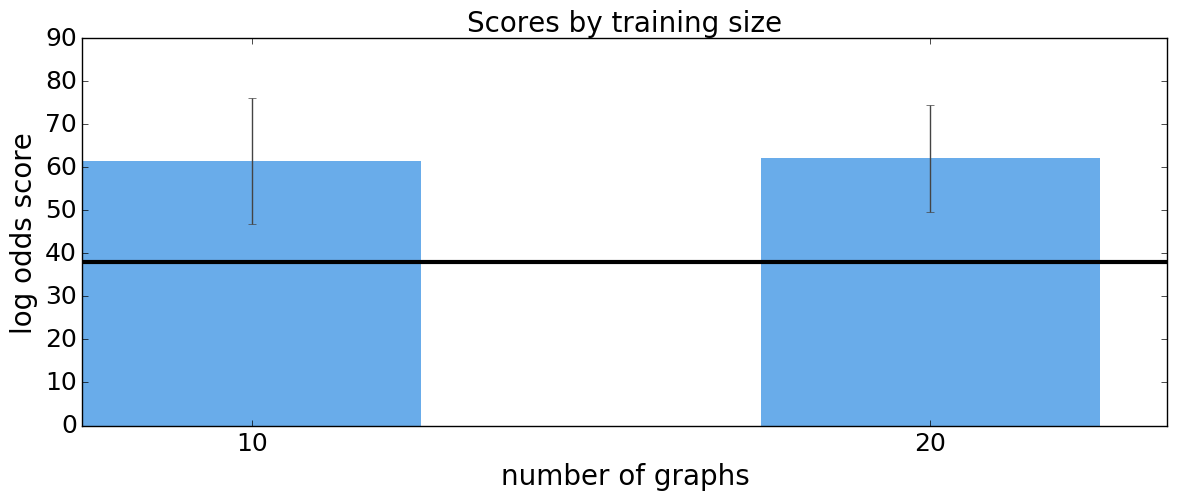

In [8]:
sizes=[10,20,50,100,200,400]
repeats=5


sizes=[10,20]
repeats=3
means = [61.460000000000001, 62.028947368421058]
stds = [14.641120175724259, 12.334871411343331]



if False:
    means=[]
    stds=[]
    for size in sizes:
        m,s=evaluate(repeats,size,fit_sample_noabstr)
        means.append(m)
        stds.append(s)
 
    
print 'size: ' + str(sizes)
print 'means: ' + str(means)
print 'stds: ' + str(stds)

make_bar_plot(sizes,means,stds)

In [9]:
eval: (10, [0.47671428571428581, 0.56468421052631579, 0.56725000000000003, 0.61272222222222217, 0.63346666666666673], [0.087741185058987883, 0.1148885284143671, 0.13075456463481305, 0.13979069175020201, 0.14890813494588273])
eval: (20, [0.58005405405405408, 0.59226470588235292, 0.61393103448275854, 0.61724242424242437, 0.62183870967741939], [0.096020534387729728, 0.11572722115101169, 0.1205292727456074, 0.12790825764010944, 0.13438866129155772])
eval: (50, [0.54162745098039211, 0.54860194174757282, 0.56912380952380948, 0.57736697247706414, 0.57792035398230079], [0.11938916373596815, 0.12429549436064462, 0.12772826030571943, 0.13639338446154581, 0.13867285941371943])
eval: (100, [0.51904830917874401, 0.52152232142857147, 0.52697663551401863, 0.53054424778761067, 0.53335714285714286], [0.13731877486463845, 0.14214535215573679, 0.14369074946790544, 0.14668797812080603, 0.14967854782299253])
eval: (200, [0.47011832946635734, 0.47532242990654205, 0.47822811059907833, 0.48037413394919171, 0.4850552884615385], [0.14088850720487028, 0.15352157071392081, 0.15520753474342225, 0.15607232727227877, 0.15826147242696156])
eval: (400, [0.47653101196953213, 0.47951224944320708, 0.4800770975056689, 0.48165380374862182, 0.49247469066366706], [0.14048955624797857, 0.14646869804046603, 0.14701883300962382, 0.15099651305453449, 0.15562144005479273])
eval: (10, [0.079250000000000001, 0.11448148148148149, 0.11473076923076923, 0.14250000000000002, 0.1428888888888889], [0.12242252108431297, 0.1427461845874898, 0.15433486320336051, 0.15554405601233426, 0.16513144782786954])
eval: (20, [0.095771929824561411, 0.096145454545454548, 0.10367272727272728, 0.12221052631578948, 0.13579245283018868], [0.13486712898011449, 0.13660734101736521, 0.14398291039456004, 0.15084746243862474, 0.15187483507103713])
eval: (50, [0.10691304347826087, 0.1121376811594203, 0.14535714285714288, 0.16431428571428572, 0.18674100719424461], [0.13688059316933654, 0.15449807428230883, 0.16261699399107674, 0.16806881676066768, 0.16869533339782722])
eval: (100, [0.10714539007092198, 0.11364179104477612, 0.12277238805970152, 0.12562043795620439, 0.13200000000000001], [0.13642713910990836, 0.13805162905000187, 0.13963606495020159, 0.14787067155537459, 0.15147735401494919])
eval: (200, [0.13589053803339518, 0.13676979742173112, 0.13774444444444445, 0.14717981651376147, 0.14968073394495413], [0.1448616198130967, 0.14959512100870487, 0.1496668739922383, 0.15120135208228183, 0.15136387805631474])
eval:
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:414: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:424: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:426: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
 (400, [0.13622109158186863, 0.14302209944751382, 0.14713135985198891, 0.14926122823098076, 0.16016007532956689], [0.14791899471690001, 0.14945693292814677, 0.14970472924155273, 0.15074901750247138, 0.15105917691823201])
size: [10, 20, 50, 100, 200, 400]
means: [56.725000000000001, 61.393103448275852, 56.91238095238095, 52.69766355140186, 47.822811059907835, 48.007709750566889][11.473076923076924, 10.367272727272727, 14.535714285714288, 12.277238805970152, 13.774444444444445, 14.713135985198891]
stds: [13.075456463481306, 12.052927274560741, 12.772826030571943, 14.369074946790544, 15.520753474342225, 14.701883300962383][15.433486320336051, 14.398291039456005, 16.261699399107673, 13.963606495020159, 14.966687399223829, 14.970472924155272]

SyntaxError: invalid syntax (<ipython-input-9-6b2d0269b937>, line 1)